In [1]:


"""function computeConsensusKernel(A, tau)

    # estimate the in-degree Laplacian 
    n = size(A,1)
    
    # println("n: ", n)
    #println("sum: ", size(sum(A, dims = 1)))

    
    Din = sum(A, dims = 1) .* Matrix(I, n, n)
    
    #println("Din: ", size(Din))
    
    Lin = Din .- A

    # calculate the consensus kernel
    kernel = exp(-tau .* Lin)
    
    return kernel
end

function computeAdvectionKernel(A, tau)

    n = size(A,1)
    Dout = sum(A, dims = 2) .* Matrix(I, n, n)
    Lout = Dout .- A

    # calculate the consensus kernel
    kernel = exp(-tau .* Lout)
    
    return kernel
end

function pruneOutDegree(AInit, pRandPrune, tau)
    A = copy(AInit)
    numNodes = size(A, 1)
    notX, nodeX = pickNodeWithInOutEdges(A, tau, pRandPrune)
    
        if pRandPrune <= rand()
            # get node x's coldest head (excluding "x")
            xHeads = findall(x -> x != 0, A[:, nodeX])
            xCutHead = xHeads[argmin(A[xHeads, nodeX])]
        else # else we randomly rewire    
            xHeads = findall(x -> x != 0, A[:, nodeX])
            ind = rand(1:length(xHeads))
            xCutHead = xHeads[ind]
        end
        
        o = A[xCutHead, nodeX]
        A[xCutHead, nodeX] = 0 

  
    return A, o, xCutHead, nodeX
end

function pruneInDegree(AInit, pRandPrune, tau)

    A = copy(AInit)
    numNodes = size(A, 1)
    
        
    notX, nodeX = pickNodeWithInOutEdges(A, tau, pRandPrune)
                
    if pRandPrune <= rand()
        #println("1")
        # get node x's coldest tail (excluding "x")
        xTails = findall(x -> x != 0, A[nodeX, :])
        xCutTail = xTails[argmin(A[nodeX, xTails])]
    else # else we randomly prune    
        #println("2")
        xTails = findall(x -> x != 0, A[nodeX, :])
        ind = rand(1:length(xTails))
        xCutTail = xTails[ind]
    end
    
    o = A[nodeX, xCutTail]
    A[nodeX, xCutTail] = 0 
    
    
    return A, o, xCutTail, nodeX 
end

function rewireOutDegree(AInit, o, xCutHead, nodeX, pRandRewire)
        A = copy(AInit)
        numNodes = size(A, 1)

        # keep a record of the other nodes
        indAll = collect(1:numNodes)
        notX = filter(x -> !(x in nodeX) && !(x == xCutHead), indAll)

        # find the nodes with no incomings from "x"
        xNonHeadBool = 1 .* Bool.(A[notX, nodeX] .== 0) 
        
        if pRandRewire <= rand()
            xNonHeads = notX[findall(x -> x != 0, xNonHeadBool)]
            xWireNonHead = xNonHeads[argmax(A[xNonHeads, nodeX])]
        else # else we randomly rewire    
            xNonHeadBoolNonzero = findall(x -> x != 0, xNonHeadBool)
            ind = rand(1:length(xNonHeadBoolNonzero))
            xWireNonHead = notX[xNonHeadBoolNonzero[ind]]
        end
        
        if xCutHead == xWireNonHead
            println("PROBLEM")
            println("The A nodes rewired are $xWireNonHead and $nodeX with weight $A[xCutHead, nodeX]")
            println("The A nodes disconnected are $xCutHead and $nodeX")
        end
    
        A[xWireNonHead, nodeX] = o
  
    return A    
end

function rewireInDegree(AInit, o, xCutTail, nodeX, pRandRewire)
       
    A = copy(AInit)
    numNodes = size(A, 1)
    
        
    # keep a record of the other nodes
    indAll = collect(1:numNodes)
    notX = filter(x -> !(x in nodeX) && !(x == xCutTail), indAll)

    # find the nodes with no incomings from "x"
        
    xNonTailBool = 1 .* Bool.(A[nodeX, notX] .== 0) 
        
    if pRandRewire <= rand()
        # get node x's hottest non-tail (excluding "x")
        xNonTails = notX[findall(x -> x != 0, xNonTailBool)]
        xWireNonTail = xNonTails[argmax(A[nodeX, xNonTails])]            
    else # else we randomly rewire    
        xNonTailBoolNonzero = findall(x -> x != 0, xNonTailBool)
        ind = rand(1:length(xNonTailBoolNonzero))
        xWireNonTail = notX[xNonTailBoolNonzero[ind]]
    end
        
    if xCutTail == xWireNonTail
        println("PROBLEM")
        println("The A nodes rewired are $xWireNonTail and $nodeX with weight $A[nodeX, xCutTail]")
        println("The A nodes disconnected are $xCutTail and $nodeX")
    end
    
    A[xWireNonTail, nodeX] = o

    
    return A
end"""




"""
function backprop(w, b, niter, trainidx, testidx, n, ntest, nbatch, layer_dims; rewire = false, λ= 0.0, LR = 0.1, p = 0.0)
    losstrn = []
    losstst = []    
    xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)
    rho = []
    tau = 4.5 
    
    t = 1 
    for k in progress(1:niter)
        xin = genbatch(trainidx, n,nbatch, ntest)
        yin = sum(xin,dims=1).%2
        dl = @diff loss(w,b,xin,yin; λ= λ)
        for i=1:length(w)
            w[i] .-= LR *grad(dl,w[i])
            b[i] .-= LR *grad(dl,b[i])
        end
         
        
        if k == 2^t 
            t += 1 
            
            A = computeKernel(w,layer_dims)

            A = runOutDynamics(A, p, tau, rewire = rewire)
            A, o, xCutHead, nodeX = pruneOutDegree(A, p, tau)

            if rewire == true
                A = rewireOutDegree(A, o, xCutHead, nodeX, p)
            end
            
            w = computeKernel_reverse(w, A, layer_dims)
        end
        
        if (k%1000==1)
            xin = genbatch(trainidx, n,ntest, ntest) # training set samples with size equal to test set
            yin = sum(xin,dims=1).%2 
            push!(losstrn,loss(w,b,xin,yin; λ= λ)) # record loss over 1000 samples
            push!(losstst,loss(w,b,xtst,ytst; λ= λ))
        end
        
    end
    
    return w, b, losstrn, losstst, rho
end
"""        

LoadError: UndefVarError: xWireNonHead not defined

In [14]:
using Revise
includet("../codebase/mlp.jl")
includet("../codebase/rewiring.jl")
using Knet, Plots, Statistics, LinearAlgebra, Random, .mlp

In [15]:
n=12 # length of input bit array
xdim = n
h1=h2=h3=2*n # hidden layer sizes
ydim = 1 # output is the probability for even parity
nbatch = 100 # number of bit strings presented at each iteration
ntest = div(2^n,8) # keep 1/8-th as test set
niter = 9*10^4 # number of training iterations

90000

In [16]:
# NN parameters
w1 = Param(randn(h1,xdim))
b1 = Param(randn(h1))
w2 = Param(randn(h2,h1))
b2 = Param(randn(h2))
w3 = Param(randn(h3,h2))
b3 = Param(randn(h3))
w4 = Param(randn(1,h3))
b4 = Param(randn(1))
w = (w1,w2,w3,w4)
b = (b1,b2,b3,b4)
layer_dims = (xdim, h1, h2, h3, ydim)

(12, 24, 24, 24, 1)

In [17]:
trainidx, testidx = mlp.gen_data(n, ntest)

([2, 3, 5, 6, 8, 9, 10, 11, 12, 13  …  4083, 4084, 4085, 4087, 4088, 4089, 4090, 4091, 4092, 4095], [480, 3040, 3937, 3427, 56, 1971, 2835, 1681, 3873, 23  …  4056, 1876, 1638, 303, 3764, 1726, 657, 1183, 143, 3956])

In [18]:
@time w, b, losstrn, losstst, rho = mlp.backprop(w, b, niter, trainidx, testidx, n, ntest, nbatch, layer_dims; LR = 0.1, λ= 0.001);

┣                    ┫ [0.00%, 1/90000, 00:00/00:00, 232342.01i/s] 

Rewiring: non-head (13,18) with head (1, 18)
Loss increasing
Rewiring: non-head (1,73) with head (40, 73)
Loss increasing


┣▍                   ┫ [1.95%, 1756/90000, 00:01/00:51, 1754.99i/s] 

Rewiring: non-head (1,70) with head (59, 70)
Loss increasing
Rewiring: non-head (13,21) with head (6, 21)
Loss increasing


┣▊                   ┫ [3.95%, 3556/90000, 00:02/00:51, 1799.40i/s] 

Rewiring: non-head (13,26) with head (2, 26)
Loss increasing
Rewiring: non-head (1,80) with head (37, 80)
Loss increasing


┣█▏                  ┫ [5.96%, 5362/90000, 00:03/00:50, 1805.71i/s] 

Rewiring: non-head (1,84) with head (49, 84)
Loss increasing
Rewiring: non-head (13,21) with head (3, 21)
Loss increasing


┣█▌                  ┫ [8.01%, 7206/90000, 00:04/00:50, 1843.87i/s] 

Rewiring: non-head (13,25) with head (4, 25)
Loss increasing


┣██                  ┫ [10.06%, 9050/90000, 00:05/00:50, 1843.96i/s] 

Rewiring: non-head (1,46) with head (20, 46)
Loss increasing
Rewiring: non-head (1,83) with head (47, 83)
Loss increasing


┣██▍                 ┫ [12.05%, 10849/90000, 00:06/00:50, 1798.72i/s] 

Rewiring: non-head (13,32) with head (3, 32)
Loss increasing
Rewiring: non-head (1,60) with head (14, 60)
Loss increasing


┣██▊                 ┫ [13.76%, 12381/90000, 00:07/00:51, 1531.54i/s] 

Rewiring: non-head (1,54) with head (25, 54)
Loss increasing


┣███▏                ┫ [15.71%, 14141/90000, 00:08/00:51, 1742.66i/s] 

Rewiring: non-head (13,16) with head (9, 16)
Loss increasing
Rewiring: non-head (1,38) with head (28, 38)
Loss increasing


┣███▌                ┫ [17.89%, 16100/90000, 00:09/00:50, 1958.58i/s] 

Rewiring: non-head (1,55) with head (31, 55)
Loss increasing
Rewiring: non-head (13,33) with head (9, 33)
Loss increasing


┣███▉                ┫ [19.90%, 17910/90000, 00:10/00:50, 1784.21i/s] 

Rewiring: non-head (1,76) with head (43, 76)
Loss increasing
Rewiring: non-head (13,30) with head (2, 30)
Loss increasing


┣████▎               ┫ [21.66%, 19492/90000, 00:11/00:51, 1581.23i/s] 

Rewiring: non-head (14,13) with head (9, 13)
Loss increasing
Rewiring: non-head (1,70) with head (59, 70)
Loss increasing


┣████▋               ┫ [23.52%, 21166/90000, 00:12/00:51, 1673.35i/s] 

Rewiring: non-head (1,68) with head (45, 68)
Loss increasing


┣█████               ┫ [25.50%, 22946/90000, 00:13/00:51, 1779.76i/s] 

Rewiring: non-head (1,82) with head (60, 82)
Loss increasing
Rewiring: non-head (13,15) with head (12, 15)
Loss increasing


┣█████▍              ┫ [27.28%, 24555/90000, 00:14/00:51, 1599.50i/s] 

Rewiring: non-head (1,58) with head (16, 58)
Loss increasing
Rewiring: non-head (13,31) with head (12, 31)
Loss increasing


┣█████▊              ┫ [29.25%, 26327/90000, 00:15/00:51, 1764.07i/s] 

Rewiring: non-head (13,22) with head (7, 22)
Loss increasing
Rewiring: non-head (1,71) with head (39, 71)
Loss increasing


┣██████▎             ┫ [31.28%, 28156/90000, 00:16/00:51, 1828.75i/s] 

Rewiring: non-head (13,28) with head (6, 28)
Loss increasing


┣██████▋             ┫ [33.32%, 29992/90000, 00:17/00:51, 1835.38i/s] 

Rewiring: non-head (1,66) with head (39, 66)
Loss increasing
Rewiring: non-head (13,36) with head (1, 36)
Loss increasing


┣███████             ┫ [35.29%, 31758/90000, 00:18/00:51, 1765.98i/s] 

Rewiring: non-head (1,45) with head (23, 45)
Loss increasing
Rewiring: non-head (1,49) with head (21, 49)
Loss increasing


┣███████▍            ┫ [37.34%, 33607/90000, 00:19/00:51, 1848.87i/s] 

Rewiring: non-head (13,23) with head (1, 23)
Loss increasing
Rewiring: non-head (1,53) with head (30, 53)
Loss increasing


┣███████▊            ┫ [39.31%, 35383/90000, 00:20/00:51, 1775.60i/s] 

Rewiring: non-head (1,41) with head (23, 41)
Loss increasing


┣████████▎           ┫ [41.28%, 37149/90000, 00:21/00:51, 1765.12i/s] 

Rewiring: non-head (1,47) with head (24, 47)
Loss increasing
Rewiring: non-head (13,16) with head (9, 16)
Loss increasing


┣████████▋           ┫ [43.29%, 38964/90000, 00:22/00:51, 1809.28i/s] 

Rewiring: non-head (1,44) with head (32, 44)
Loss increasing
Rewiring: non-head (13,26) with head (2, 26)
Loss increasing


┣█████████           ┫ [45.34%, 40805/90000, 00:23/00:51, 1840.91i/s] 

Rewiring: non-head (13,29) with head (12, 29)
Loss increasing
Rewiring: non-head (1,58) with head (16, 58)
Loss increasing


┣█████████▍          ┫ [47.27%, 42545/90000, 00:24/00:51, 1739.83i/s] 

Rewiring: non-head (1,63) with head (45, 63)
Loss increasing
Rewiring: non-head (13,19) with head (12, 19)
Loss increasing


┣█████████▊          ┫ [49.22%, 44295/90000, 00:25/00:51, 1749.17i/s] 

Rewiring: non-head (1,49) with head (21, 49)
Loss increasing


┣██████████▏         ┫ [51.16%, 46047/90000, 00:26/00:51, 1751.32i/s] 

Rewiring: non-head (1,76) with head (43, 76)
Loss increasing
Rewiring: non-head (1,64) with head (42, 64)
Loss increasing


┣██████████▋         ┫ [53.15%, 47832/90000, 00:27/00:51, 1784.36i/s] 

Rewiring: non-head (1,64) with head (42, 64)
Loss increasing
Rewiring: non-head (1,57) with head (22, 57)
Loss increasing


┣███████████         ┫ [55.03%, 49528/90000, 00:28/00:51, 1695.46i/s] 

Rewiring: non-head (1,54) with head (25, 54)
Loss increasing
Rewiring: non-head (13,34) with head (9, 34)
Loss increasing


┣███████████▍        ┫ [56.94%, 51248/90000, 00:29/00:51, 1719.99i/s] 

Rewiring: non-head (1,46) with head (20, 46)
Loss increasing


┣███████████▊        ┫ [58.89%, 53002/90000, 00:30/00:51, 1751.81i/s] 

Rewiring: non-head (13,17) with head (1, 17)
Loss increasing
Rewiring: non-head (1,69) with head (50, 69)
Loss increasing


┣████████████▏       ┫ [60.93%, 54836/90000, 00:31/00:51, 1833.94i/s] 

Rewiring: non-head (1,48) with head (27, 48)
Loss increasing
Rewiring: non-head (1,47) with head (24, 47)
Loss increasing


┣████████████▌       ┫ [62.84%, 56557/90000, 00:32/00:51, 1720.46i/s] 

Rewiring: non-head (13,34) with head (9, 34)
Loss increasing
Rewiring: non-head (1,42) with head (21, 42)
Loss increasing


┣████████████▉       ┫ [64.83%, 58345/90000, 00:33/00:51, 1787.69i/s] 

Rewiring: non-head (1,72) with head (37, 72)
Loss increasing


┣█████████████▎      ┫ [66.76%, 60084/90000, 00:34/00:51, 1738.68i/s] 

Rewiring: non-head (1,83) with head (47, 83)
Loss increasing
Rewiring: non-head (1,39) with head (22, 39)
Loss increasing


┣█████████████▋      ┫ [68.68%, 61808/90000, 00:35/00:51, 1723.97i/s] 

Rewiring: non-head (1,47) with head (24, 47)
Loss increasing
Rewiring: non-head (1,37) with head (28, 37)
Loss increasing


┣██████████████      ┫ [70.58%, 63522/90000, 00:36/00:51, 1713.59i/s] 

Rewiring: non-head (1,62) with head (55, 62)
Loss increasing


┣██████████████▍     ┫ [72.34%, 65102/90000, 00:37/00:51, 1579.71i/s] 

Rewiring: non-head (1,56) with head (21, 56)
Loss increasing
Rewiring: non-head (1,39) with head (22, 39)
Loss increasing


┣██████████████▊     ┫ [74.31%, 66876/90000, 00:38/00:51, 1773.26i/s] 

Rewiring: non-head (1,45) with head (23, 45)
Loss increasing
Rewiring: non-head (1,81) with head (38, 81)
Loss increasing


┣███████████████▏    ┫ [76.10%, 68491/90000, 00:39/00:51, 1614.99i/s] 

Rewiring: non-head (1,62) with head (44, 62)
Loss increasing
Rewiring: non-head (1,76) with head (43, 76)
Loss increasing


┣███████████████▌    ┫ [77.99%, 70188/90000, 00:40/00:51, 1696.47i/s] 

Rewiring: non-head (1,41) with head (23, 41)
Loss increasing


┣███████████████▉    ┫ [79.90%, 71906/90000, 00:41/00:51, 1717.99i/s] 

Rewiring: non-head (13,30) with head (3, 30)
Loss increasing
Rewiring: non-head (1,83) with head (47, 83)
Loss increasing


┣████████████████▍   ┫ [81.90%, 73709/90000, 00:42/00:51, 1802.82i/s] 

Rewiring: non-head (1,71) with head (39, 71)
Loss increasing
Rewiring: non-head (1,55) with head (31, 55)
Loss increasing


┣████████████████▊   ┫ [83.97%, 75575/90000, 00:43/00:51, 1831.22i/s] 

Rewiring: non-head (13,15) with head (12, 15)
Loss increasing
Rewiring: non-head (13,26) with head (2, 26)
Loss increasing


┣█████████████████▏  ┫ [86.02%, 77414/90000, 00:44/00:51, 1838.95i/s] 

Rewiring: non-head (1,84) with head (49, 84)
Loss increasing
Rewiring: non-head (1,58) with head (16, 58)
Loss increasing


┣█████████████████▋  ┫ [88.13%, 79315/90000, 00:45/00:51, 1900.87i/s] 

Rewiring: non-head (1,73) with head (40, 73)
Loss increasing
Rewiring: non-head (1,74) with head (44, 74)
Loss increasing


┣██████████████████  ┫ [90.16%, 81145/90000, 00:46/00:51, 1829.14i/s] 

Rewiring: non-head (1,45) with head (23, 45)
Loss increasing


┣██████████████████▍ ┫ [92.31%, 83082/90000, 00:47/00:51, 1936.75i/s] 

Rewiring: non-head (13,25) with head (10, 25)
Loss increasing
Rewiring: non-head (13,34) with head (9, 34)
Loss increasing


┣██████████████████▊ ┫ [94.34%, 84906/90000, 00:48/00:51, 1810.38i/s] 

Rewiring: non-head (1,80) with head (37, 80)
Loss increasing
Rewiring: non-head (13,36) with head (1, 36)
Loss increasing


┣███████████████████▎┫ [96.42%, 86780/90000, 00:49/00:51, 1873.40i/s] 

Rewiring: non-head (13,29) with head (12, 29)
Loss increasing
Rewiring: non-head (13,30) with head (3, 30)
Loss increasing


┣███████████████████▋┫ [98.52%, 88667/90000, 00:50/00:51, 1886.52i/s] 

Rewiring: non-head (1,42) with head (21, 42)
Loss increasing


┣████████████████████┫ [100.00%, 90000/90000, 00:51/00:51, 1772.40i/s] 


 50.780129 seconds (103.76 M allocations: 38.795 GiB, 18.17% gc time)


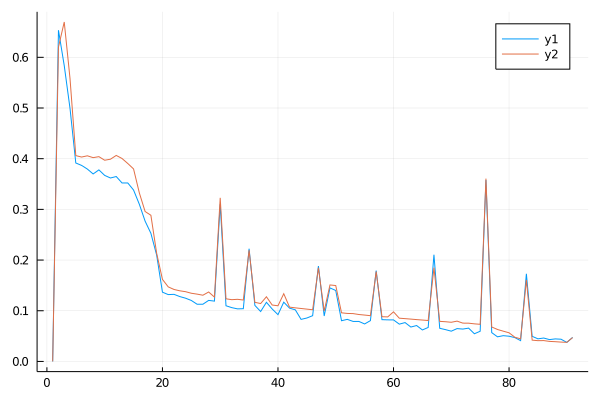

In [19]:
plot(losstrn)
plot!(losstst) 

In [20]:
xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)

([0 0 … 1 1; 0 0 … 1 1; … ; 1 1 … 0 1; 0 1 … 0 1], [1 0 … 0 0], [0 1 … 0 1; 0 0 … 0 1; … ; 0 0 … 1 0; 0 0 … 1 0], [0 0 … 1 0])

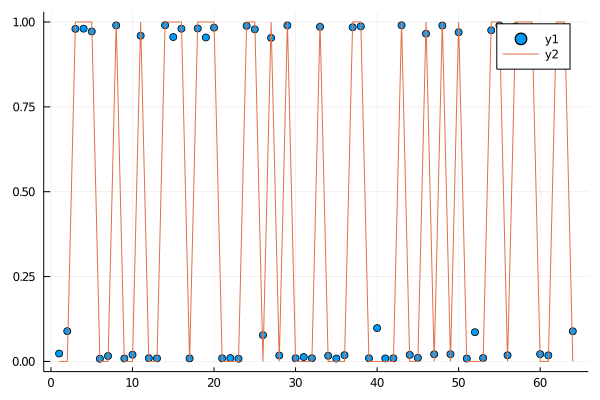

In [21]:
np=min(ntest,64)
scatter(pred(w,b,xtst)[1:np]
#    ,xlim=(0,np)
)
plot!(ytst[1:np])

In [22]:
# accuracy
function acc(x,y)
    cnt = 0
    tot = length(x[1,:])
    for i=1:tot-1
        chk = (pred(w,b,x[:,i])[1] - y[i][1])^2
        if (chk < 0.5)
            cnt += 1
        end
    end
    return 1.0*cnt/tot
end

trainidx, testidx = mlp.gen_data(n, ntest)
xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)

([0 0 … 1 1; 0 0 … 1 1; … ; 0 1 … 0 1; 1 0 … 1 1], [1 1 … 1 0], [1 1 … 1 1; 0 0 … 1 0; … ; 1 1 … 1 1; 0 1 … 1 0], [0 1 … 1 1])

In [23]:
acc(xtrn,ytrn),acc(xtst,ytst)

(0.9938598939436226, 0.9921875)

In [24]:
sumtrn = 0.0; sumtst = 0.0

for i=1:100
    trainidx, testidx = mlp.gen_data(n, ntest)
    xtrn, ytrn, xtst, ytst = mlp.split_data(trainidx, testidx, n, ntest)
    sumtrn += acc(xtrn,ytrn); sumtst += acc(xtst,ytst)
end

(sumtrn/100,sumtst/100) 

(0.9938710577728156, 0.99212890625)

In [25]:
plot(losscheck)

LoadError: UndefVarError: losscheck not defined